In [30]:
import numpy as np
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
%matplotlib inline

def rsa_corr(X,y):
    estimator = EmpiricalCovariance()
    scaler=StandardScaler()
    labels=np.unique(y)
    nf=X.shape[1]
    matrix={}
    cov_matrix_all=np.zeros((len(labels)*nf,len(labels)*nf))
    for i,i_label in enumerate(sorted(labels)):
        matrix[i]={}
        for j,j_label in enumerate(sorted(labels)):
            X_cond=X[np.logical_or(y==i_label,y==j_label)]           
            X_cond_scale=scaler.fit_transform(X_cond)   
            estimator.fit(X_cond_scale)
            tmpmatrix=estimator.covariance_ 
            matrix[i][j]=1-tmpmatrix
            #matrix[i][j]=tmpmatrix
            ni=i*nf
            nj=j*nf
            cov_matrix_all[ni:ni+nf,nj:nj+nf]=1-estimator.covariance_
            #cov_matrix_all[ni:ni+nf,nj:nj+nf]=estimator.covariance_
            
    return cov_matrix_all,matrix

In [38]:

# Behavioral DATA
fold_g = 'F:/IRM_Marche/'
smt='ss'       
names='ap','as','boh','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
label=np.loadtxt(fold_g+'label_main.txt','S12')
block=np.loadtxt(fold_g+'block_main.txt','int')
motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_whole70_basc444asym.np','int')
index=np.array((10,35,47,50,52,67,69,70,80,89,91,95,108,110,111,121,124,126,139,142,144,148,154,176,184,191,195,199,200,
               201,206,213,218,233,244,257,264,266,267,268,273,275,279,281,283,285,287,299,303,336,344,351,363,365,
               378,381,387,403,432))
#sma=np.array((428,89,437,424,230,67,392))
imag=np.array((268,344,67,154,275,35,257,52,213,273,403,432,266,10,195,126,283,89))
#stim=np.array((285,387,108,279,381,121,200,378,206,299,69,144,148,50))
#hand=np.array((47,264,365,303,351,281,154,244,432,267,199,257,111,70,287,89,124,110,201,69))
#foot=np.array((108,91,80,403,52,218,176,50,191,233,378,336,195,184,363,95,139,142))

motor_region=np.sort(imag)
n_loop=motor_region.shape[0]
# Remove data not analysed
mask_block=block==block
for x in range(label.shape[0]):
    if label[x,2]!=label[x-1,2]:
        mask_block[x]=False
    elif label[x,2]!=label[x-2,2]:
        mask_block[x]=False
c_des_out=np.logical_not(label[:,2]== b'des')
tmp_out= np.logical_and(c_des_out,mask_block)
c_rest_out=np.logical_not(label[:,0]== b'rest')
cond_out= np.logical_and(tmp_out,c_rest_out)
y=label[cond_out,2]
labels=np.unique(y)
# Prepare correlation
estimator = EmpiricalCovariance()
scaler=StandardScaler()
# Create np array
result_matrix = np.empty([len(names),motor_region.shape[0]*labels.shape[0],motor_region.shape[0]*labels.shape[0]])
#Analysis for each subject
for i,n in enumerate(sorted(names)):
    roi_name=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'   
    roi=np.load(roi_name)['roi'][cond_out]
    roi=roi[:,motor_region-1]
    result_matrix[i],matrices=rsa_corr(roi,y)


Sanity check on RDM matrices

In [32]:
result_matrix.shape


(23, 736, 736)

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

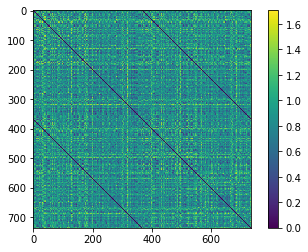

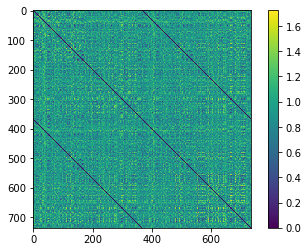

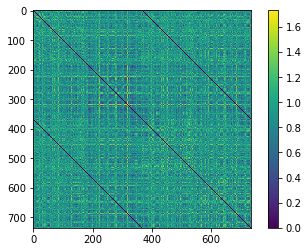

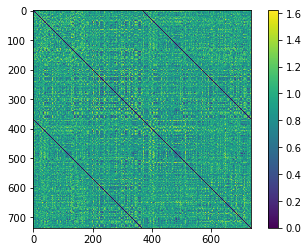

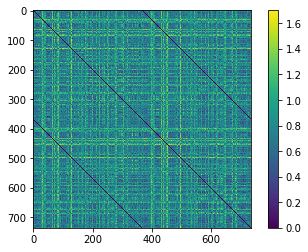

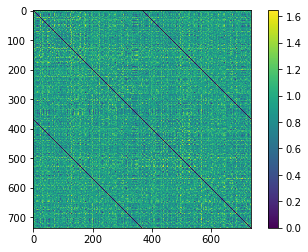

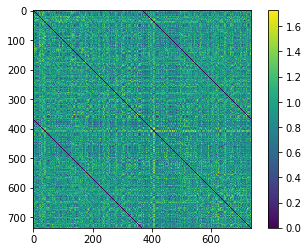

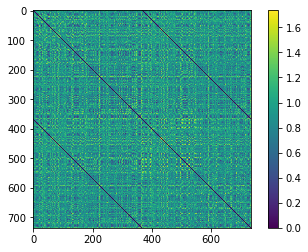

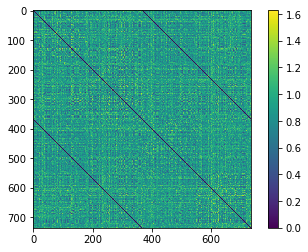

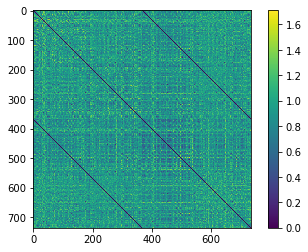

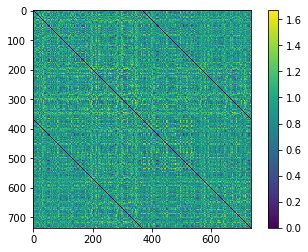

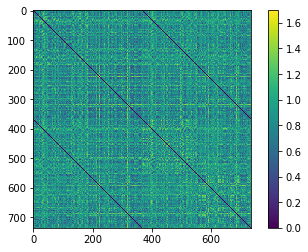

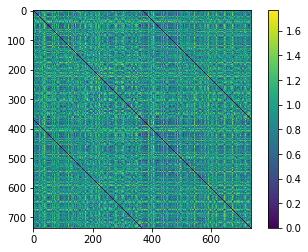

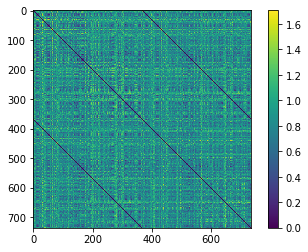

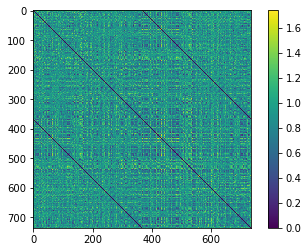

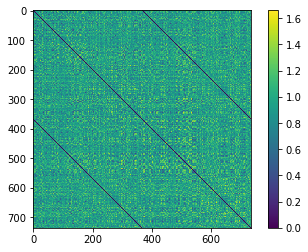

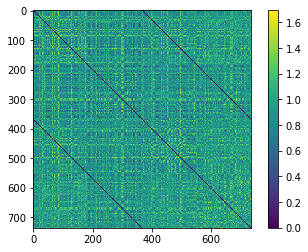

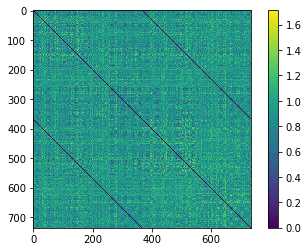

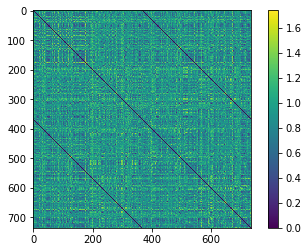

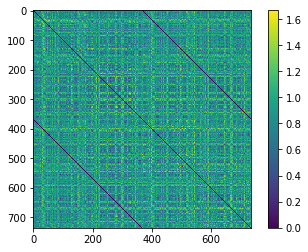

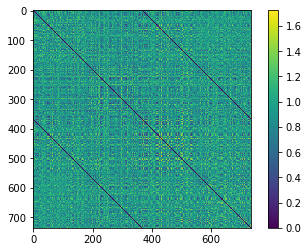

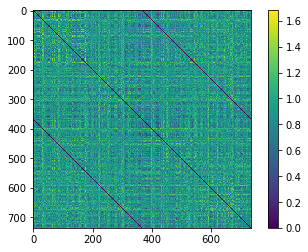

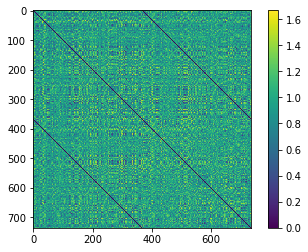

In [34]:
for c in result_matrix:
    plt.imshow(c,interpolation='nearest')
    plt.colorbar()
    plt.show()

Summarizing across subjects (grand average)

In [39]:
RDM_matrices_grav = result_matrix.mean(axis=0)
print(RDM_matrices_grav.shape)

(72, 72)


In [15]:
from sklearn.manifold import MDS

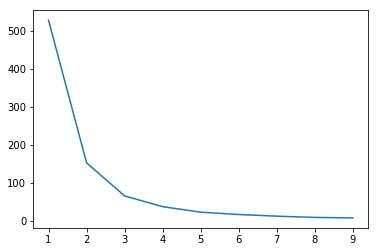

In [43]:

allstress = []
for k in range(1,10):
    mymds = MDS(dissimilarity='precomputed',n_components=k)
    mymds.fit(RDM_matrices_grav)
    allstress.append(mymds.stress_)
    
plt.plot(range(1,10),allstress)

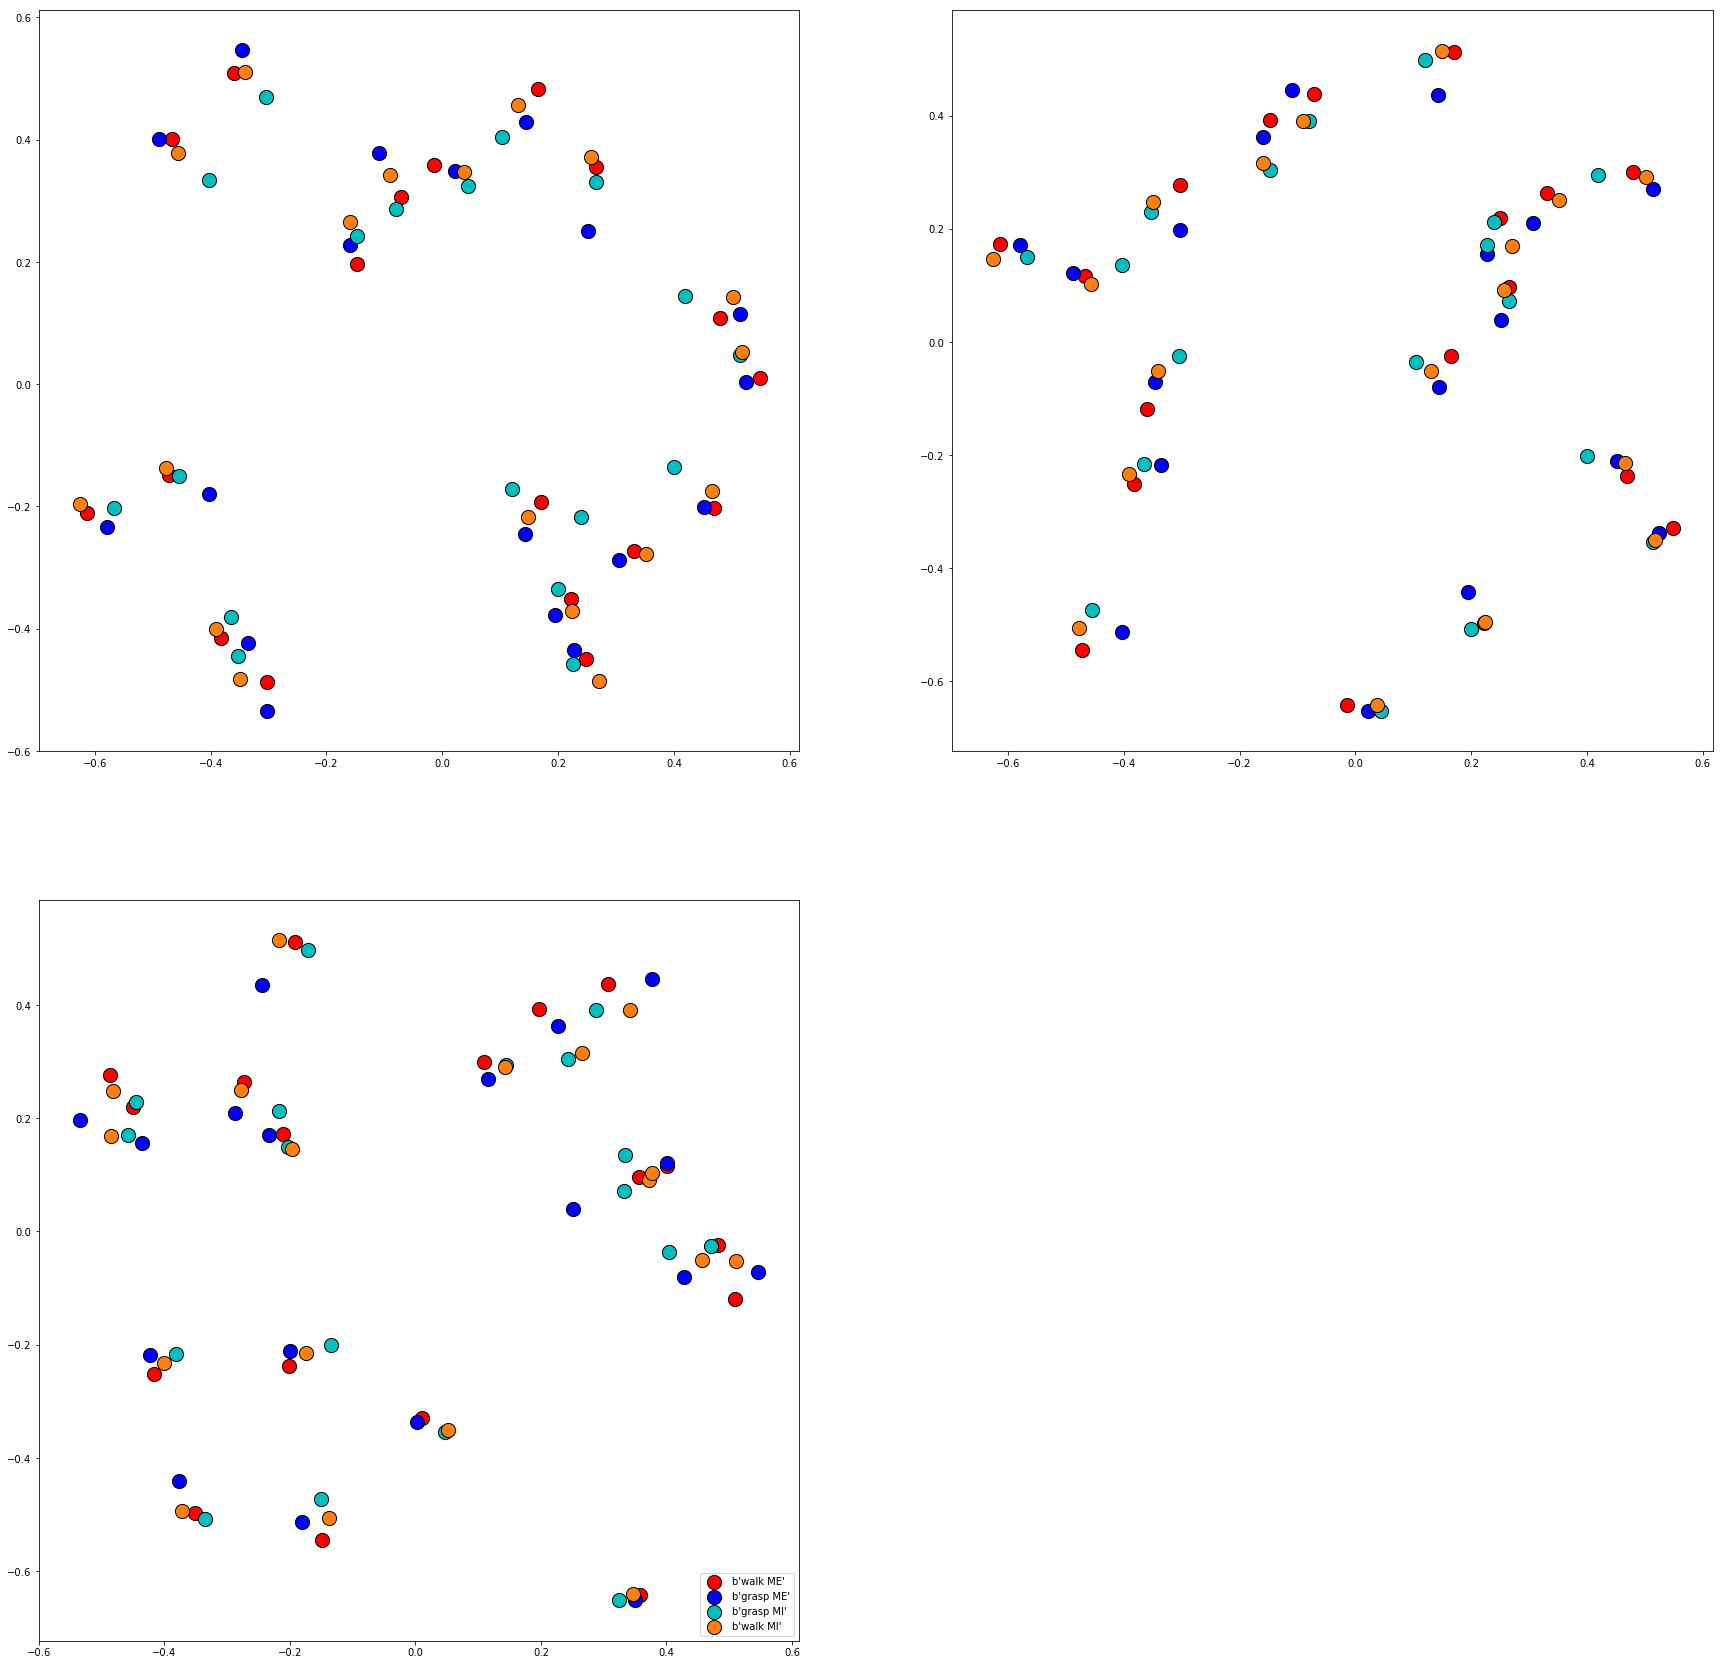

In [42]:
from sklearn.manifold import MDS
from math import sqrt
ncompmds = 3
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

colors = ['r', 'b','c','tab:orange']
names = sorted(labels)
names =[w.replace(b'imp', b'walk ME') for w in names]
names =[w.replace(b'mboug', b'grasp ME') for w in names]
names =[w.replace(b'mimag', b'grasp MI') for w in names]
names =[w.replace(b'pimag', b'walk MI') for w in names]
nsub=int(sqrt(n_loop))
idx=motor_region.shape[0]
mds_res = mymds.fit_transform(RDM_matrices_grav)
fig=plt.figure(figsize=(30,30))
size=200
for i,color in enumerate(colors):
    name=names[i]
    ax1=fig.add_subplot(2,2,1)
    ax1.scatter(mds_res[idx*i:idx*(i+1),0], mds_res[idx*i:idx*(i+1), 1], 
               facecolor=color,edgecolors='k',label=name,s=size)
    ax2=fig.add_subplot(2,2,2)
    ax2.scatter(mds_res[idx*i:idx*(i+1),0], mds_res[idx*i:idx*(i+1), 2], 
               facecolor=color,edgecolors='k',label=name,s=size)
    ax3=fig.add_subplot(2,2,3)
    ax3.scatter(mds_res[idx*i:idx*(i+1),1], mds_res[idx*i:idx*(i+1), 2], 
               facecolor=color,edgecolors='k',label=name,s=size)

plt.legend(loc='lower right')

fig.savefig('Z:/GitHub/irm_marche/rsa_imag_all.png')




In [21]:
mds_res.shape[0]/4
motor_region.shape
mds_res[idx*i:idx*i+1,0]
idx*i:

SyntaxError: invalid syntax (<ipython-input-21-09193195ac40>, line 4)

In [ ]:
nroi

In [ ]:
from sklearn.manifold import MDS
ncompmds = 2
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

plt.figure()
for nroi in range(n_loop):
    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
    for i,color in enumerate(colors):
        name=names[i]
        plt.scatter(mds_res[i, 0], mds_res[i, 1], 
               facecolors=color, label=name, edgecolors='k',)
#plt.figure()
#for nroi in range(184):
#    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
#    for i,color in enumerate(colors):
#        name=names[i]
 #       plt.scatter(mds_res[i, 0], mds_res[i, 2], 
#               facecolors=color, label=name, edgecolors='k',)
#plt.figure()
#for nroi in range(184):
#    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
#    for i,color in enumerate(colors):
#        name=names[i]
#        plt.scatter(mds_res[i, 1], mds_res[i, 2], 
 #              facecolors=color, label=name, edgecolors='k',)

In [ ]:
from networkx.convert_matrix import from_numpy_matrix

In [ ]:
G = from_numpy_matrix(RDM_matrices_reduced_grav.mean(axis=0))

In [ ]:
posdict = G.node_dict_factory({0:mds_res[0],1:mds_res[1],2:mds_res[2],3:mds_res[3]})

In [ ]:
from networkx.drawing.nx_pylab import draw

draw(G,posdict)